In [2]:
import numpy as np
import matplotlib.pyplot as plt
import re

In [14]:
file="../evaluation/TEST/allds-atco-nop"
data = open(file,'r').readlines()

In [15]:
out = {}
name=None
for line in data:
    if ("EVAL MODEL" in line):
        name=line.strip().split(' ')[-2].split('/')[-1]
        out[name]={}
    elif name in out:
        dataset = re.search(r'DATASET: ([a-zA-Z_]+)', line)
        wer = re.search(r'WER: ([\d.]+)', line)
        loss = re.search(r'LOSS: ([\d.]+)', line)
        if dataset is None or wer is None and loss is None:
            continue
        out[name][dataset.group(1)]={
            'wer': float(wer.group(1) if not None else 0.0),
            'loss': float(loss.group(1) if not None else 0.0)
        }
            


In [16]:
# number of examples in dataset
num_examples = {
    'atco_en_ruzyne': 70,
    'atco_en_stefanik': 53,
    'atco_en_zurich': 412,
    'atco_fr': 33,
    'atco_other_lang': 40
}

In [17]:
# total wer
checkpoints =[]
wer = {'total':[]}
loss = {'total':[]}
for checkpoint,ds_set in out.items():
    checkpoints.append(checkpoint)
    total_wer = 0
    total_loss = 0
    for ds_name,wer_loss in ds_set.items():
        if ds_name not in wer:
            wer[ds_name] = []
        if ds_name not in loss:
            loss[ds_name] = []
        wer[ds_name].append(wer_loss['wer'])
        loss[ds_name].append(wer_loss['loss'])
        total_wer += wer_loss['wer'] * num_examples[ds_name]
        total_loss += wer_loss['loss'] * num_examples[ds_name]
    # average wer and loss
    wer['total'].append(total_wer / sum(num_examples.values()))
    loss['total'].append(total_loss / sum(num_examples.values()))

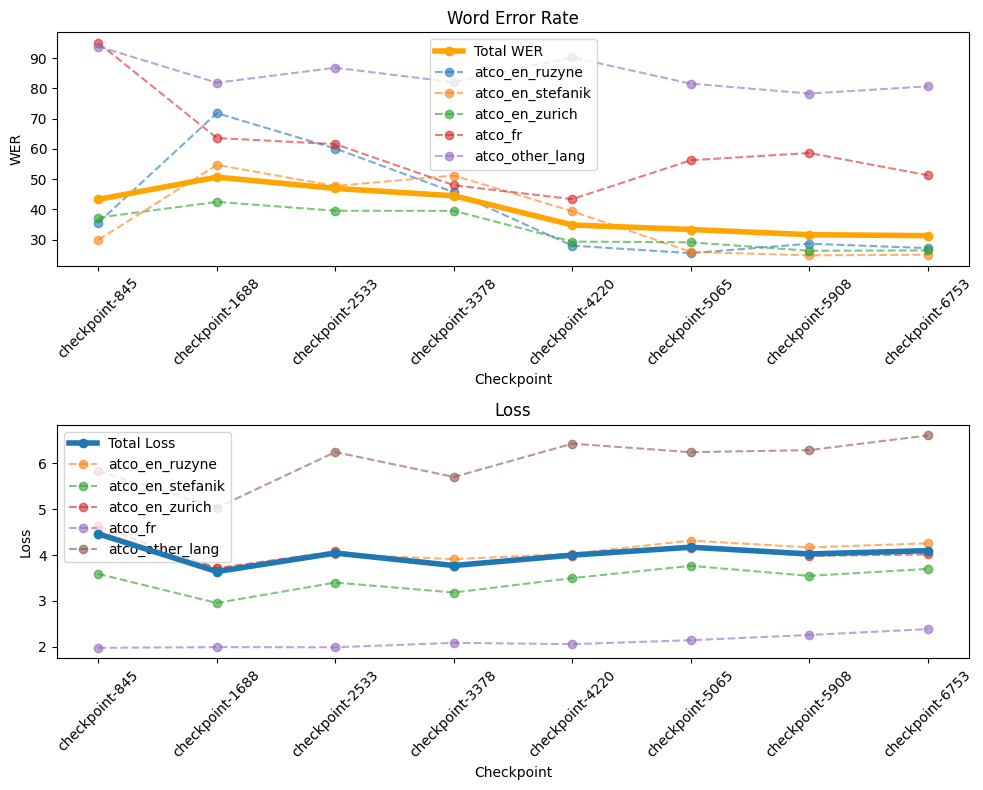

In [19]:
fig,ax = plt.subplots(2,1,figsize=(10,8))
# plot WER
for ds_name in wer:
    if ds_name == 'total':
        ax[0].plot(checkpoints,wer['total'],linewidth=4, marker='o',color='orange', label='Total WER', zorder=10)
        continue
    ax[0].plot(checkpoints,wer[ds_name],linestyle='--', marker='o',alpha=0.6, label=ds_name)
ax[0].set_xlabel('Checkpoint')
ax[0].tick_params(axis='x', rotation=45)
ax[0].set_ylabel('WER')
ax[0].set_title('Word Error Rate')
ax[0].legend()
# plot loss
for ds_name in loss:
    if ds_name == 'total':
        ax[1].plot(checkpoints,loss['total'],linewidth=4, marker='o', label='Total Loss', zorder=10)
        continue
    ax[1].plot(checkpoints,loss[ds_name],linestyle='--', marker='o',alpha=0.6, label=ds_name)

ax[1].set_xlabel('Checkpoint')
ax[1].set_ylabel('Loss')
ax[1].tick_params(axis='x', rotation=45)
ax[1].set_title('Loss')
ax[1].legend()
plt.tight_layout()
plt.savefig('../evaluation/TEST/allds-atco-nop.png', dpi=300)

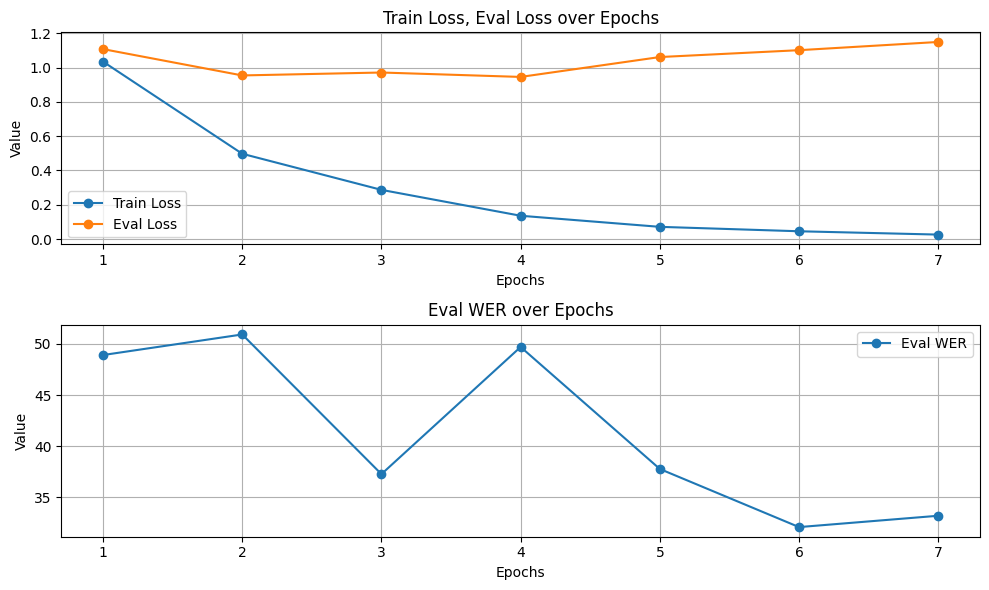

In [22]:
# Data for the graph
epochs = [1, 2, 3, 4, 5, 6,7]
train_loss = [1.034900, 0.497400, 0.286800, 0.135800, 0.071100, 0.045300, 0.025900]
eval_loss = [1.108031, 0.954353, 0.971437, 0.945680, 1.061698, 1.101715, 1.149648]
eval_wer = [48.908584, 50.919087, 37.272280, 49.696373, 37.772854, 32.094206, 33.202035]

# Plotting the graph
fig,ax=plt.subplots(2,1,figsize=(10, 6))
ax[0].plot(epochs, train_loss, marker='o', label='Train Loss')
ax[0].plot(epochs, eval_loss, marker='o', label='Eval Loss')

# Adding labels, title, and legend
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Value')
ax[0].set_title('Train Loss, Eval Loss over Epochs')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(epochs, eval_wer, marker='o', label='Eval WER')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Value')
ax[1].set_title('Eval WER over Epochs')
ax[1].legend()
ax[1].grid(True)

plt.tight_layout()

# Display the graph
# plt.show()
plt.savefig('../evaluation/TEST/NEWatco-atco-nop_loss_wer.png', dpi=300)